# Reconstruction of volume from simulated data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import conjugate_gradient, get_cg_vol_ops
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
from pyfftw.builders import irfft2

plt.rcParams["figure.figsize"]=8,8

### Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

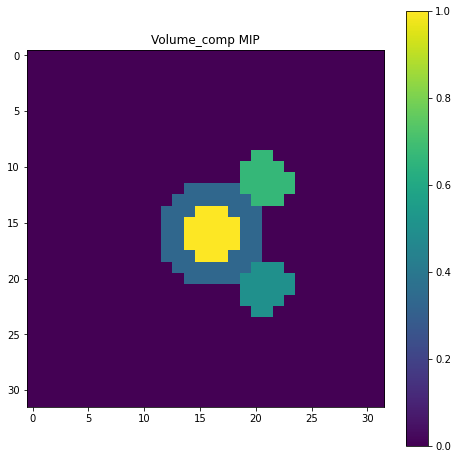

In [3]:
nx = 32
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])
pixel_size = dimensions[0]/shape[0]

# A volume with components
centres = np.array([[0,0,0], [3, 3, 0], [3, -3, 0], [0,0,3]])
radii = np.array([3, 1.5, 1.5, 1.5])
intensities = np.array([10,15,20, 20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, False))
vol_fourier, x_grid, _ = volume_fourier(vol, pixel_size)

y_grid = x_grid
z_grid = x_grid

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

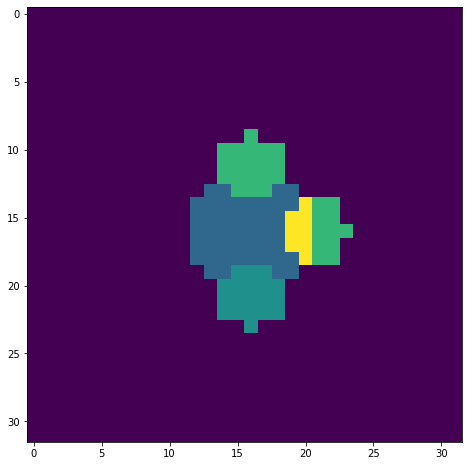

In [4]:
mip_y(vol)

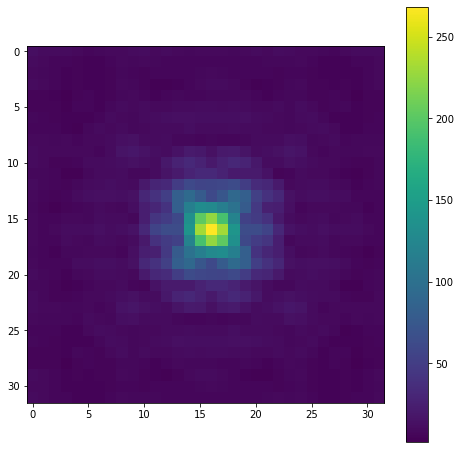

In [5]:
mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()

### Generate the data

CTF

In [6]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
dfiter = df.iterrows()
_, p = next(dfiter)

#ctf_params = {'def1'  : p[star.Relion.DEFOCUSU], 
#              'def2'  : p[star.Relion.DEFOCUSV],
#              'angast': p[star.Relion.DEFOCUSANGLE], 
#              'phase' : p[star.Relion.PHASESHIFT],
#              'kv'    : p[star.Relion.VOLTAGE],
#              'ac'    : p[star.Relion.AC], 
#              'cs'    : p[star.Relion.CS], 
#              'bf'    : 0,
#              'lp'    : 2 * pixel_size}

ctf_params0 = np.array([p[star.Relion.DEFOCUSU],
                      p[star.Relion.DEFOCUSV],
                      p[star.Relion.DEFOCUSANGLE], 
                      p[star.Relion.PHASESHIFT],
                      p[star.Relion.VOLTAGE],
                      p[star.Relion.AC],
                      p[star.Relion.CS],
                      0,
                      2 * pixel_size])

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


Generate projections (in Fourier domain)

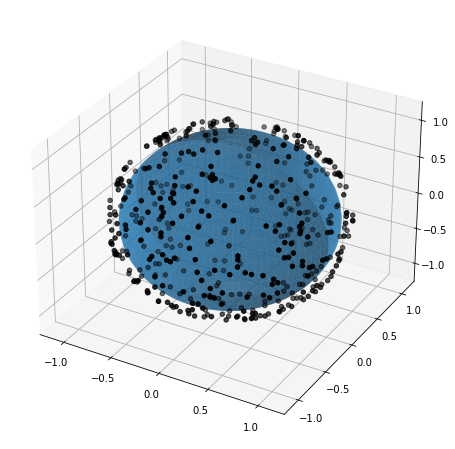

In [7]:
# Orientations
N = 4000

#s = 0.05
s = 0.1
angles_true = generate_uniform_orientations(N)
#jnp.array(np.random.rand(N,3))*jnp.pi*2

#angles_true = jnp.array(np.random.rand(N,3))*jnp.pi/4 + jnp.pi

# Non uniformly distributed orientations (here, two clusters)
#angles_true = s*np.random.randn(int(N),3)
#angles_true = np.concatenate([s*np.random.randn(2250,3), 
#                             s*np.random.randn(2250,3)+np.pi*2/3, 
#                              np.random.rand(500,3)*jnp.pi*2
#                             ], axis=0)
#np.random.shuffle(angles_true)
#angles_true = jnp.array(angles_true)

#angles_true = np.zeros([N,3])
#angles_true[:,1] = s*np.random.randn(N) - np.pi/2
#angles_true = jnp.array(angles_true)

plot_angles(angles_true[:500])

In [8]:
angles_true.shape

(4000, 3)

3.935926914215088
0.40067071764468065


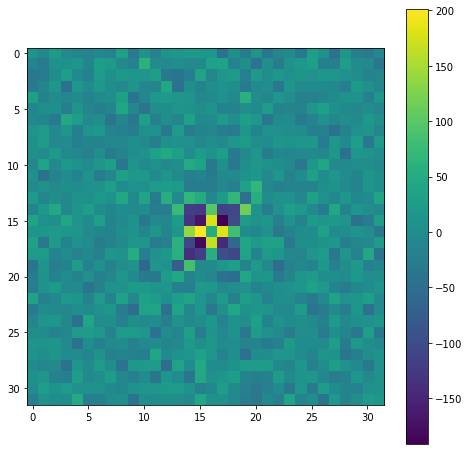

In [9]:
radius = 0.8
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

img0 = slice_func(vol_fourier, [0,0,0], [0,0], ctf_params0)


shifts_true = jnp.zeros([N,3])
ctf_params = jnp.array([ctf_params0] * N)
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true, shifts_true, ctf_params)

norm0 = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

# Noise
imgs += (np.random.randn(N, nx*nx) + 1j*np.random.randn(N, nx*nx)) * jnp.max(img0) *0.1

norm1 = jnp.real(jnp.sum(jnp.conj(imgs)*imgs))

print(time.time()-start)

#SNR
print(norm0/norm1)

plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

### Crop images and volume:

In [10]:
old_nx = jnp.sqrt(imgs.shape[1]).astype(jnp.int64)
nx = 32

if old_nx > 32:
    imgs = imgs.reshape(imgs.shape[0], old_nx, old_nx)
    imgs, x_grid = crop_fourier_images(imgs, x_grid, nx)
    imgs = imgs.reshape(imgs.shape[0], nx*nx)
    #imgs2 = imgs2.reshape(imgs2.shape[0], nx*nx)

    vol_fourier, _ = crop_fourier_volume(vol_fourier, x_grid, nx)

    y_grid = x_grid
    z_grid = x_grid

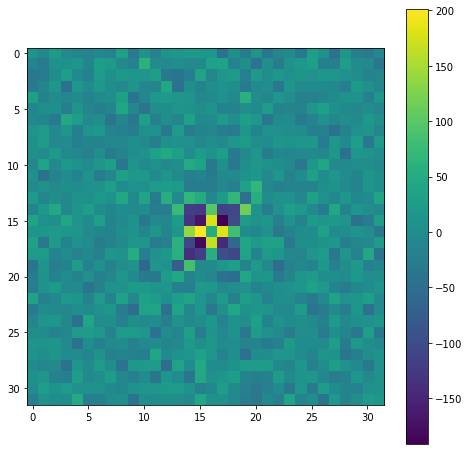

In [11]:
plt.imshow(jnp.fft.fftshift(jnp.real(imgs[103].reshape(nx,nx)))); plt.colorbar()

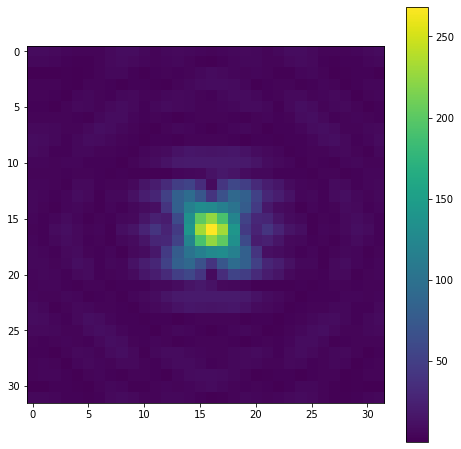

In [12]:
#mip_z(jnp.fft.fftshift(jnp.abs((vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.abs((vol_fourier[:,:,0])))); plt.colorbar()

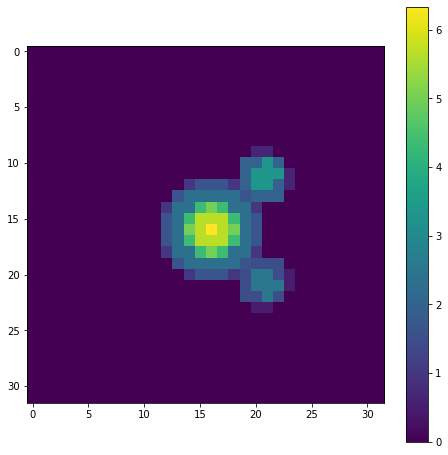

In [13]:
#mip_z(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier)))); plt.colorbar()
plt.imshow(jnp.fft.fftshift(jnp.real(jnp.fft.ifftn(vol_fourier[:,:,0])))); plt.colorbar()

### Loss functions for the new dimension

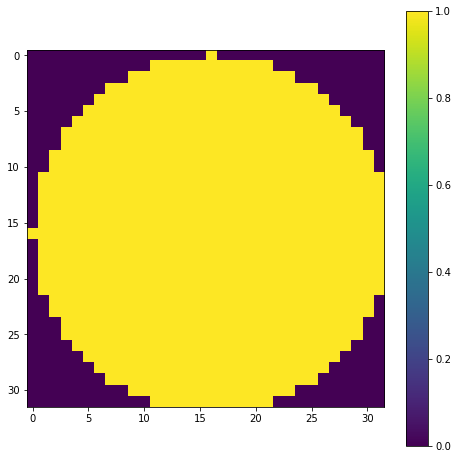

In [14]:
#alpha = 0.01
alpha = 0

radius = 0.8 # for nx=32
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

In [15]:
start = time.time()
ll = loss_func_batched(vol_fourier, angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20])
#ll = loss_func_batched(np.random.randn(nx,nx,nx), angles_true[:20], shifts_true[:20], ctf_params[:20], imgs[:20])
print(time.time()-start)
print(ll.shape)

5.947390079498291
(20,)


Gradients with respect to volume pixels, over all (or a batch of) images

In [16]:
start = time.time()
ll = grad_loss_volume(np.random.randn(nx,nx,nx), angles_true[0],  shifts_true[0], ctf_params[0], imgs[0])
print(time.time()-start)
print(ll.shape)

2.430610418319702
(32, 32, 32)


Doing the below with N large enough (e.g. 1000) makes it run out of memory (trying to allocate >200GB)

In [17]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(np.random.randn(nx,nx,nx), angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx])
print(time.time()-start)
print(ll.shape)

3.533175468444824
(32, 32, 32)


### Orientations

In [18]:
imgs.shape

(4000, 1024)

300
Iter  0
  Time orientations sampling = 5.057560682296753
  cg iter 0 ||r|| = 1.951539670235984
  cg iter 50 ||r|| = 0.009076317909677186
  cg iter 100 ||r|| = 0.0019667573218428843
  cg iter 150 ||r|| = 0.00041167390200794445
  cg iter 200 ||r|| = 0.00011369507499963361
  cg iter 250 ||r|| = 3.578856053628369e-05
  Time cg = 9.057039976119995


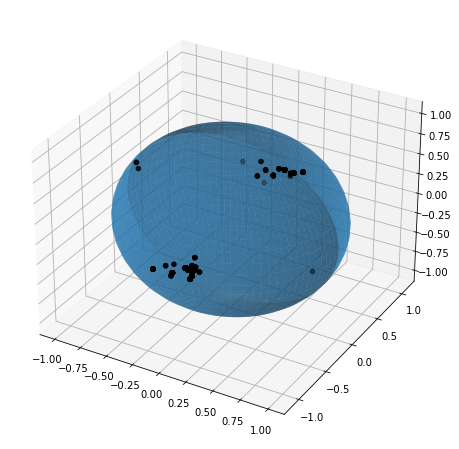

Iter  1
  Time orientations sampling = 2.602449893951416
  cg iter 0 ||r|| = 0.7745656421719841
  cg iter 50 ||r|| = 0.000695349150252873
  cg iter 100 ||r|| = 0.0008870065462591747
  cg iter 150 ||r|| = 0.0034904524840210596
  cg iter 200 ||r|| = 0.0006814675386107559
  cg iter 250 ||r|| = 0.0002203013182890838
  Time cg = 10.358149528503418
Iter  2
  Time orientations sampling = 2.0642833709716797
  cg iter 0 ||r|| = 0.7714221797276268
  cg iter 50 ||r|| = 0.012343819610355553
  cg iter 100 ||r|| = 0.000147284872570178
  cg iter 150 ||r|| = 0.00011518789163842488
  cg iter 200 ||r|| = 8.792507945233704e-05
  cg iter 250 ||r|| = 8.814202279972962e-05
  Time cg = 6.675468444824219
Iter  3
  Time orientations sampling = 2.2891898155212402
  cg iter 0 ||r|| = 0.7568879039936884
  cg iter 50 ||r|| = 0.007551743731207432
  cg iter 100 ||r|| = 0.00013868757380382148
  cg iter 150 ||r|| = 0.00012295365954888117
  cg iter 200 ||r|| = 7.053697100520656e-05
  cg iter 250 ||r|| = 8.2575475006858

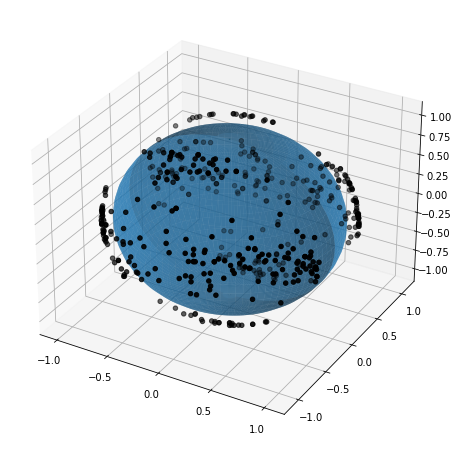

Iter  5
  Time orientations sampling = 2.8057913780212402
  cg iter 0 ||r|| = 0.48936516491854165
  cg iter 50 ||r|| = 0.0002502521972684476
  cg iter 100 ||r|| = 0.0012922368931888467
  cg iter 150 ||r|| = 0.0005083706376830636
  cg iter 200 ||r|| = 0.00026828225103262687
  cg iter 250 ||r|| = 0.00010663251989668006
  Time cg = 11.475611686706543
Iter  6
  Time orientations sampling = 2.1522626876831055
  cg iter 0 ||r|| = 0.5304981751758987
  cg iter 50 ||r|| = 0.0008968252678235771
  cg iter 100 ||r|| = 0.00015105007544053637
  cg iter 150 ||r|| = 0.0001496465219655598
  cg iter 200 ||r|| = 6.759870791851093e-05
  cg iter 250 ||r|| = 5.31263145987556e-05
  Time cg = 7.344470262527466
Iter  7
  Time orientations sampling = 2.5430023670196533
  cg iter 0 ||r|| = 0.5430188190316296
  cg iter 50 ||r|| = 0.008739684252455408
  cg iter 100 ||r|| = 0.00012907758448321195
  cg iter 150 ||r|| = 4.662074519963551e-05
  cg iter 200 ||r|| = 4.520563830311584e-05
  cg iter 250 ||r|| = 5.46135986

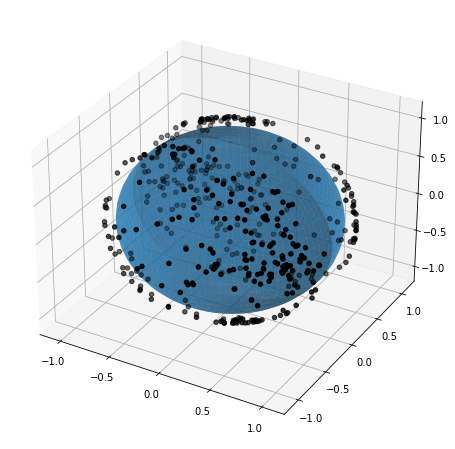

Iter  9
  Time orientations sampling = 2.8131444454193115
  cg iter 0 ||r|| = 0.3975210375130822
  cg iter 50 ||r|| = 0.0019208463843822068
  cg iter 100 ||r|| = 0.00012483288687199065
  cg iter 150 ||r|| = 0.0001232580535791228
  cg iter 200 ||r|| = 0.0004069811269787424
  cg iter 250 ||r|| = 0.0002381117519493532
  Time cg = 11.617112636566162
Iter  10
  Time orientations sampling = 2.1104583740234375
  cg iter 0 ||r|| = 0.39749311049279784
  cg iter 50 ||r|| = 0.00027418778614121073
  cg iter 100 ||r|| = 0.00035581923211072664
  cg iter 150 ||r|| = 0.00016901132143897187
  cg iter 200 ||r|| = 8.590240298872844e-05
  cg iter 250 ||r|| = 5.287291656232985e-05
  Time cg = 7.942803621292114
Iter  11
  Time orientations sampling = 2.19730544090271
  cg iter 0 ||r|| = 0.3931190785638489
  cg iter 50 ||r|| = 0.0016785314339110085
  cg iter 100 ||r|| = 7.844134228349415e-05
  cg iter 150 ||r|| = 5.827382448801076e-05
  cg iter 200 ||r|| = 4.620782096657176e-05
  cg iter 250 ||r|| = 3.227756

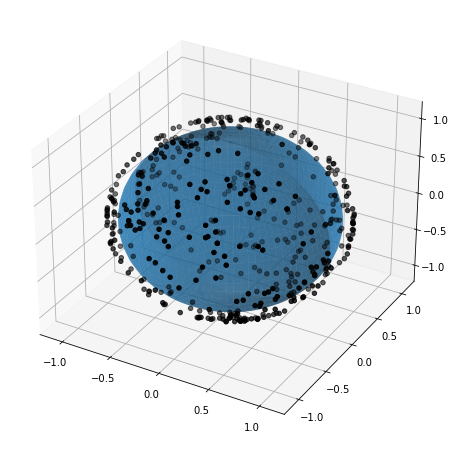

Iter  13
  Time orientations sampling = 2.0797650814056396
  cg iter 0 ||r|| = 0.41593908797186807
  cg iter 50 ||r|| = 0.00014135092981548878
  cg iter 100 ||r|| = 6.592345309613743e-05
  cg iter 150 ||r|| = 4.151516911652856e-05
  cg iter 200 ||r|| = 3.2760439051485575e-05
  cg iter 250 ||r|| = 2.9617273023790738e-05
  Time cg = 7.216660022735596
Iter  14
  Time orientations sampling = 2.0311279296875
  cg iter 0 ||r|| = 0.41672980813108096
  cg iter 50 ||r|| = 8.925086484294452e-05
  cg iter 100 ||r|| = 5.553423076316823e-05
  cg iter 150 ||r|| = 4.025384326554715e-05
  cg iter 200 ||r|| = 3.9727522413617744e-05
  cg iter 250 ||r|| = 2.913583556102017e-05
  Time cg = 7.803067684173584
Iter  15
  Time orientations sampling = 2.2391722202301025
  cg iter 0 ||r|| = 0.4166445465286767
  cg iter 50 ||r|| = 9.690105998792171e-05
  cg iter 100 ||r|| = 4.941218343001363e-05
  cg iter 150 ||r|| = 4.395270295841191e-05
  cg iter 200 ||r|| = 3.503303106662116e-05
  cg iter 250 ||r|| = 2.963948

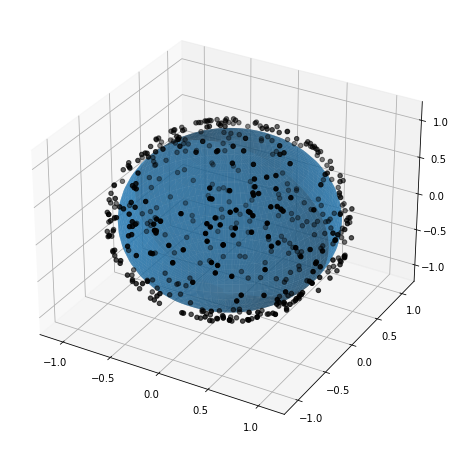

Iter  17
  Time orientations sampling = 3.264439821243286
  cg iter 0 ||r|| = 0.31505404182914015
  cg iter 50 ||r|| = 9.782806447632288e-05
  cg iter 100 ||r|| = 6.615171292152811e-05
  cg iter 150 ||r|| = 5.070733959295672e-05
  cg iter 200 ||r|| = 3.633777230139965e-05
  cg iter 250 ||r|| = 2.582925081866379e-05
  Time cg = 14.560186386108398
Iter  18
  Time orientations sampling = 2.383441209793091
  cg iter 0 ||r|| = 0.3166277738867506
  cg iter 50 ||r|| = 8.104216754554219e-05
  cg iter 100 ||r|| = 6.0765497934929005e-05
  cg iter 150 ||r|| = 4.1755368983474284e-05
  cg iter 200 ||r|| = 3.724736449223913e-05
  cg iter 250 ||r|| = 3.50286916198244e-05
  Time cg = 8.356417179107666
Iter  19
  Time orientations sampling = 2.291813611984253
  cg iter 0 ||r|| = 0.3174219481087445
  cg iter 50 ||r|| = 8.292353959848291e-05
  cg iter 100 ||r|| = 6.81731788526176e-05
  cg iter 150 ||r|| = 4.658082604861368e-05
  cg iter 200 ||r|| = 3.7429594473598105e-05
  cg iter 250 ||r|| = 3.457005462

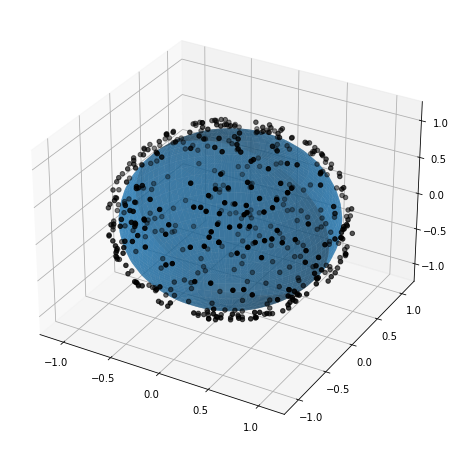

Iter  21
  Time orientations sampling = 3.0690855979919434
  cg iter 0 ||r|| = 0.24559795298994136
  cg iter 50 ||r|| = 0.00011805152032465317
  cg iter 100 ||r|| = 6.959923326453259e-05
  cg iter 150 ||r|| = 5.156541239169323e-05
  cg iter 200 ||r|| = 3.467229372065314e-05
  cg iter 250 ||r|| = 3.669546973935672e-05
  Time cg = 13.660442113876343
Iter  22
  Time orientations sampling = 2.1683127880096436
  cg iter 0 ||r|| = 0.2468007726028464
  cg iter 50 ||r|| = 8.840587758158003e-05
  cg iter 100 ||r|| = 6.202341437417102e-05
  cg iter 150 ||r|| = 3.982563294580183e-05
  cg iter 200 ||r|| = 3.786948317709671e-05
  cg iter 250 ||r|| = 3.054861018042649e-05
  Time cg = 9.578568696975708
Iter  23
  Time orientations sampling = 2.41447114944458
  cg iter 0 ||r|| = 0.24620071174600688
  cg iter 50 ||r|| = 0.00011264645658403846
  cg iter 100 ||r|| = 6.125707678014645e-05
  cg iter 150 ||r|| = 4.771617053680025e-05
  cg iter 200 ||r|| = 3.747917399284446e-05
  cg iter 250 ||r|| = 4.103091

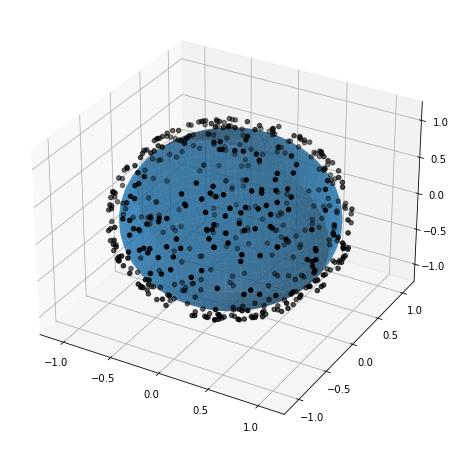

Iter  25
  Time orientations sampling = 2.8645758628845215
  cg iter 0 ||r|| = 0.19522655498353125
  cg iter 50 ||r|| = 7.895746657223035e-05
  cg iter 100 ||r|| = 5.674400887823854e-05
  cg iter 150 ||r|| = 3.7851906773763336e-05
  cg iter 200 ||r|| = 4.1295499314002515e-05
  cg iter 250 ||r|| = 3.268448279847656e-05
  Time cg = 17.012127161026
Iter  26
  Time orientations sampling = 2.3047566413879395
  cg iter 0 ||r|| = 0.1953563977265792
  cg iter 50 ||r|| = 9.864955887845177e-05
  cg iter 100 ||r|| = 5.908220656447842e-05
  cg iter 150 ||r|| = 4.81785734498362e-05
  cg iter 200 ||r|| = 3.509766165267503e-05
  cg iter 250 ||r|| = 3.8969040781436285e-05
  Time cg = 11.85308051109314
Iter  27
  Time orientations sampling = 2.3107657432556152
  cg iter 0 ||r|| = 0.195533584463053
  cg iter 50 ||r|| = 9.655351142901888e-05
  cg iter 100 ||r|| = 6.225705597386718e-05
  cg iter 150 ||r|| = 4.904178060512963e-05
  cg iter 200 ||r|| = 3.8051849103236e-05
  cg iter 250 ||r|| = 3.76603258670

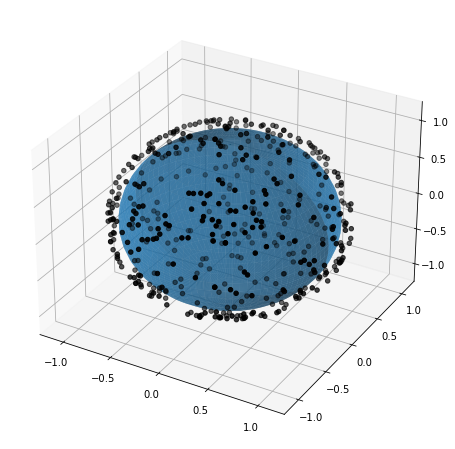

Iter  29
  Time orientations sampling = 3.2299976348876953
  cg iter 0 ||r|| = 0.15857952232562428
  cg iter 50 ||r|| = 9.307208497423116e-05
  cg iter 100 ||r|| = 5.4955989636255267e-05
  cg iter 150 ||r|| = 4.424259226564773e-05
  cg iter 200 ||r|| = 3.606053331973732e-05
  cg iter 250 ||r|| = 2.9112464259114996e-05
  Time cg = 18.266912698745728
Iter  30
  Time orientations sampling = 2.373856782913208
  cg iter 0 ||r|| = 0.1586179684892264
  cg iter 50 ||r|| = 0.00010562621941493203
  cg iter 100 ||r|| = 5.969183222024246e-05
  cg iter 150 ||r|| = 8.879015590185164e-05
  cg iter 200 ||r|| = 6.253987135378401e-05
  cg iter 250 ||r|| = 5.964381584428855e-05
  Time cg = 13.574655532836914
Iter  31
  Time orientations sampling = 2.876973867416382
  cg iter 0 ||r|| = 0.15846500849476206
  cg iter 50 ||r|| = 8.218188874606903e-05
  cg iter 100 ||r|| = 6.255851862334321e-05
  cg iter 150 ||r|| = 4.71084954218655e-05
  cg iter 200 ||r|| = 4.452173104460438e-05
  cg iter 250 ||r|| = 3.65432

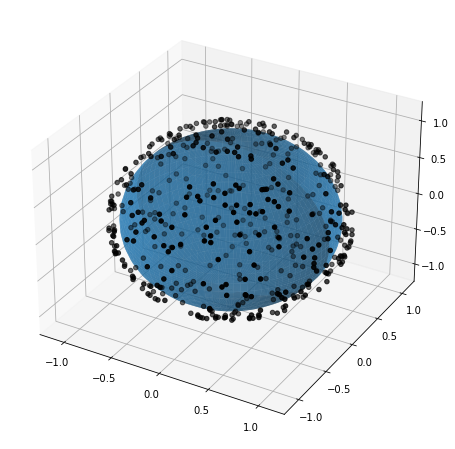

Iter  33
  Time orientations sampling = 3.286221742630005
  cg iter 0 ||r|| = 0.13134867580146675
  cg iter 50 ||r|| = 0.00011954280301570951
  cg iter 100 ||r|| = 6.918891588604695e-05
  cg iter 150 ||r|| = 5.527417949415183e-05
  cg iter 200 ||r|| = 3.5346037502683274e-05
  cg iter 250 ||r|| = 4.246068553288185e-05
  Time cg = 21.163737535476685
Iter  34
  Time orientations sampling = 2.934253215789795
  cg iter 0 ||r|| = 0.13132821125910332
  cg iter 50 ||r|| = 0.00010974748738416359
  cg iter 100 ||r|| = 5.2956365975860436e-05
  cg iter 150 ||r|| = 4.514138967417627e-05
  cg iter 200 ||r|| = 3.410491958832891e-05
  cg iter 250 ||r|| = 3.468211852313938e-05
  Time cg = 16.298003435134888
Iter  35
  Time orientations sampling = 2.342491626739502
  cg iter 0 ||r|| = 0.13148967336582068
  cg iter 50 ||r|| = 0.0001241832787142809
  cg iter 100 ||r|| = 7.165489144393266e-05
  cg iter 150 ||r|| = 4.5635693814774804e-05
  cg iter 200 ||r|| = 4.3756909865332124e-05
  cg iter 250 ||r|| = 2.8

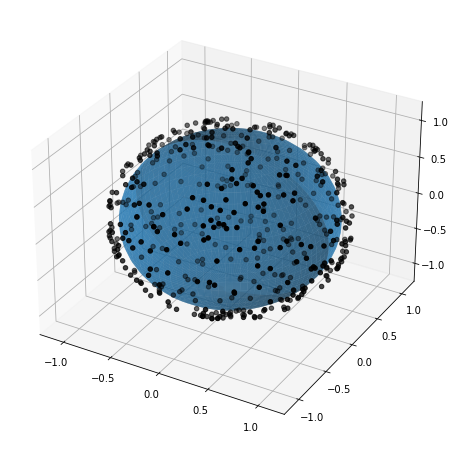

Iter  37
  Time orientations sampling = 4.462576627731323
  cg iter 0 ||r|| = 0.11071223191856878
  cg iter 50 ||r|| = 0.00011190610162812976
  cg iter 100 ||r|| = 5.0704464430241526e-05
  cg iter 150 ||r|| = 3.873397450352934e-05
  cg iter 200 ||r|| = 4.282543781335823e-05
  cg iter 250 ||r|| = 3.613324171738385e-05
  Time cg = 22.573053121566772
Iter  38
  Time orientations sampling = 2.518484354019165
  cg iter 0 ||r|| = 0.11081768684010836
  cg iter 50 ||r|| = 9.153319203894133e-05
  cg iter 100 ||r|| = 5.9613556720906734e-05
  cg iter 150 ||r|| = 4.017143602371697e-05
  cg iter 200 ||r|| = 3.891455292096393e-05
  cg iter 250 ||r|| = 3.120604082080587e-05
  Time cg = 18.099833726882935
Iter  39
  Time orientations sampling = 2.4581239223480225
  cg iter 0 ||r|| = 0.11067152252518951
  cg iter 50 ||r|| = 0.00012861956524872406
  cg iter 100 ||r|| = 6.84456993891433e-05
  cg iter 150 ||r|| = 5.930078775023758e-05
  cg iter 200 ||r|| = 4.330977878886903e-05
  cg iter 250 ||r|| = 3.694

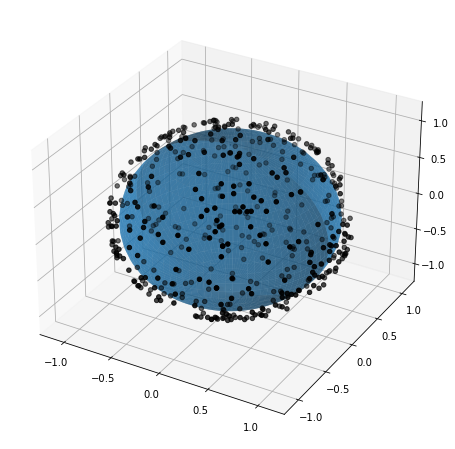

Iter  41
  Time orientations sampling = 3.363215208053589
  cg iter 0 ||r|| = 0.08151718278199929
  cg iter 50 ||r|| = 0.00010238139013006255
  cg iter 100 ||r|| = 6.85632833800567e-05
  cg iter 150 ||r|| = 5.037400503591596e-05
  cg iter 200 ||r|| = 4.295909400052746e-05
  cg iter 250 ||r|| = 3.765600069146631e-05
  Time cg = 28.915143251419067
Iter  42
  Time orientations sampling = 2.47834849357605
  cg iter 0 ||r|| = 0.08169676757944347
  cg iter 50 ||r|| = 8.778508950433888e-05
  cg iter 100 ||r|| = 4.598803124004878e-05
  cg iter 150 ||r|| = 3.9596105970595734e-05
  cg iter 200 ||r|| = 3.671350825630072e-05
  cg iter 250 ||r|| = 2.7978693864989075e-05
  Time cg = 24.079741716384888
Iter  43
  Time orientations sampling = 2.3019020557403564
  cg iter 0 ||r|| = 0.08156138842285302
  cg iter 50 ||r|| = 8.678238016030986e-05
  cg iter 100 ||r|| = 5.196565923069979e-05
  cg iter 150 ||r|| = 3.415567097206967e-05
  cg iter 200 ||r|| = 2.8709508709299707e-05
  cg iter 250 ||r|| = 2.6320

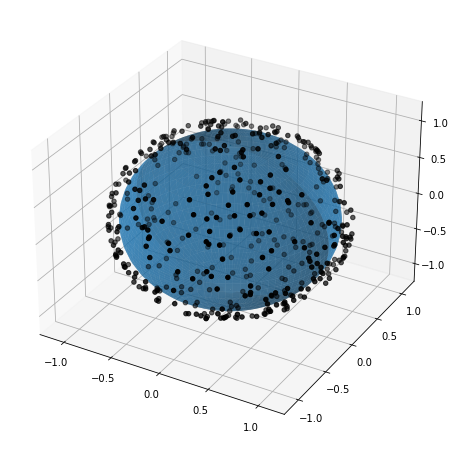

Iter  45
  Time orientations sampling = 3.411137104034424
  cg iter 0 ||r|| = 0.07123217011395974
  cg iter 50 ||r|| = 0.00010818063138085913
  cg iter 100 ||r|| = 7.918532925362402e-05
  cg iter 150 ||r|| = 6.503976522528765e-05
  cg iter 200 ||r|| = 6.027138425781925e-05
  cg iter 250 ||r|| = 4.2184763156455925e-05
  Time cg = 32.090901136398315
Iter  46
  Time orientations sampling = 2.4183833599090576
  cg iter 0 ||r|| = 0.0710445119991666
  cg iter 50 ||r|| = 0.00012543547820607627
  cg iter 100 ||r|| = 7.318372669007864e-05
  cg iter 150 ||r|| = 6.098817117766692e-05
  cg iter 200 ||r|| = 4.684488149271631e-05
  cg iter 250 ||r|| = 3.685325995606617e-05
  Time cg = 28.61880660057068
Iter  47
  Time orientations sampling = 2.3185205459594727
  cg iter 0 ||r|| = 0.0709584053622862
  cg iter 50 ||r|| = 9.604583500599818e-05
  cg iter 100 ||r|| = 7.151697388697536e-05
  cg iter 150 ||r|| = 4.135471379532851e-05
  cg iter 200 ||r|| = 3.7429550687010603e-05
  cg iter 250 ||r|| = 3.9333

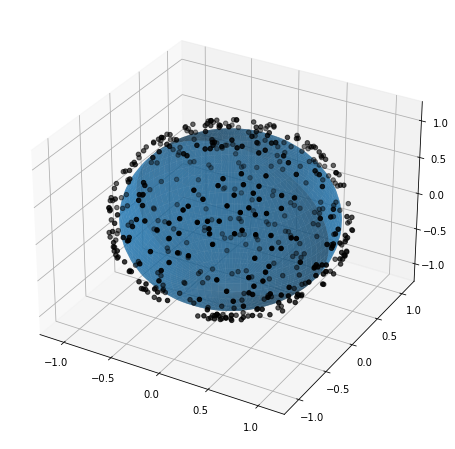

Iter  49
  Time orientations sampling = 3.401750087738037
  cg iter 0 ||r|| = 0.06236322837320526
  cg iter 50 ||r|| = 0.0001121137164581993
  cg iter 100 ||r|| = 7.733487625632041e-05
  cg iter 150 ||r|| = 5.504701597021322e-05
  cg iter 200 ||r|| = 5.1222992650518206e-05
  cg iter 250 ||r|| = 3.5481500118920474e-05
  Time cg = 32.840944051742554


In [19]:
from src.ab_initio import ab_initio

N_samples = 40000
N_iter = 100
N_cg_iter = 300
dr = 0.05
radius = 0.1
alpha = 0

out_dir = '../data/'
imgs = imgs.reshape([N, nx*nx])
vcg = ab_initio(project, imgs, shifts_true, ctf_params, x_grid, N_iter, N_cg_iter, N_samples, radius, dr, alpha, 'tri', False, True, True, out_dir)

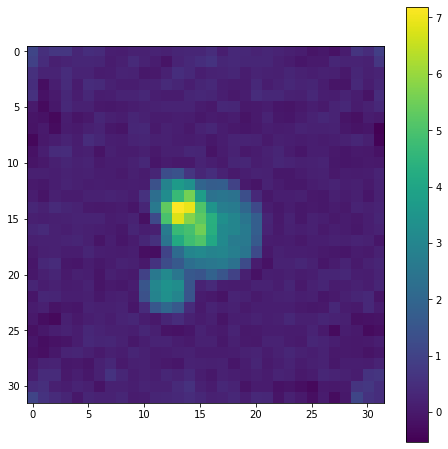

In [20]:
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg[0,:,:])))); plt.colorbar()

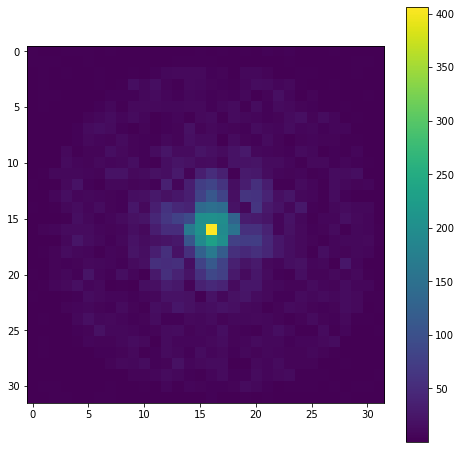

In [21]:
plt.imshow(jnp.abs(jnp.fft.fftshift(vcg[:,:,0]))); plt.colorbar()

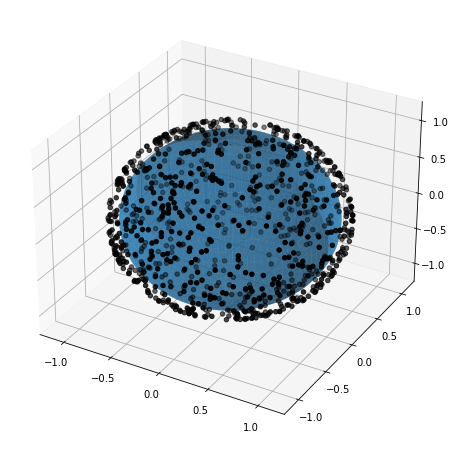

In [22]:
#angles_r = generate_uniform_orientations(400)
plot_angles(angles_true[:1000])

In [23]:
vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg)))
#v0 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier)))

In [24]:
with mrcfile.new('../data/simulated_rec3.mrc', overwrite=True) as mrc:
    mrc.set_data(vr.astype(np.float32))

## Optimization with respect to volume

### CG - applied to two halves of the data

In [25]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
N_iter = 500

N2 = jnp.floor(N/2).astype(jnp.int64)
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[:N2], shifts_true[:N2], ctf_params[:N2], imgs[:N2], v0.shape)

vcg1,_ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

  cg iter 0 ||r|| = 0.06304271502789192
  cg iter 50 ||r|| = 0.00012975482737407313
  cg iter 100 ||r|| = 5.588698784579466e-05
  cg iter 150 ||r|| = 5.132682220687937e-05
  cg iter 200 ||r|| = 3.7399054210145344e-05
  cg iter 250 ||r|| = 4.015155828600023e-05
  cg iter 300 ||r|| = 3.0208346961944906e-05
  cg iter 350 ||r|| = 2.355656307158632e-05
  cg iter 400 ||r|| = 2.543841047821242e-05
  cg iter 450 ||r|| = 2.6160799290180253e-05


In [26]:
AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:], v0.shape)

vcg2, _ = conjugate_gradient(AA2, Ab2, v0, N_iter, verbose = True)

  cg iter 0 ||r|| = 0.06318779361125863
  cg iter 50 ||r|| = 0.0001347262582397813
  cg iter 100 ||r|| = 6.135974980092986e-05
  cg iter 150 ||r|| = 5.1786354274041617e-05
  cg iter 200 ||r|| = 4.283521563712001e-05
  cg iter 250 ||r|| = 2.6935417901266576e-05
  cg iter 300 ||r|| = 3.8497330192707467e-05
  cg iter 350 ||r|| = 3.013386393316648e-05
  cg iter 400 ||r|| = 2.7968746290533806e-05
  cg iter 450 ||r|| = 2.9415328414340626e-05


In [27]:
#print("Final loss function = ", loss_func_sum(vcg, angles_true, shifts_true, ctf_params, imgs))
print("Relative error = ", jnp.max(jnp.abs((vcg1 - vol_fourier)/jnp.max(vol_fourier))))
print("Absolute error = ", jnp.mean(jnp.abs((vcg1 - vol_fourier))))

Relative error =  0.30540686566472053
Absolute error =  6.400866087837501


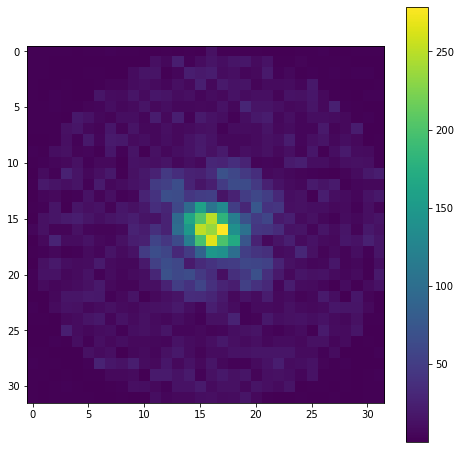

In [28]:
#mip_z(jnp.abs(jnp.fft.fftshift((vcg1)))) ; 
plt.imshow(jnp.abs(jnp.fft.fftshift((vcg1[0,:,:])))) ; 
plt.colorbar()

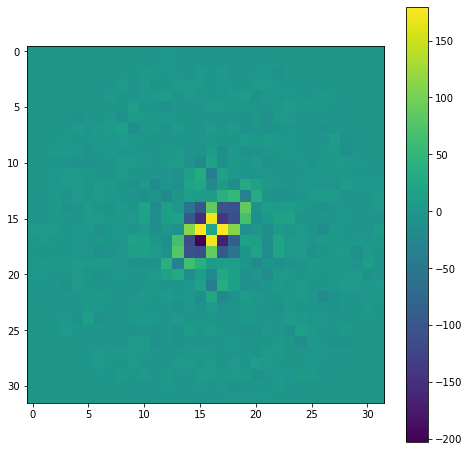

In [29]:
idx = 709

s0 = slice_func(vcg1, angles_true[idx], shifts_true[idx], ctf_params[idx])
plt.imshow(jnp.fft.fftshift(jnp.real(s0).reshape(nx,nx))); plt.colorbar()

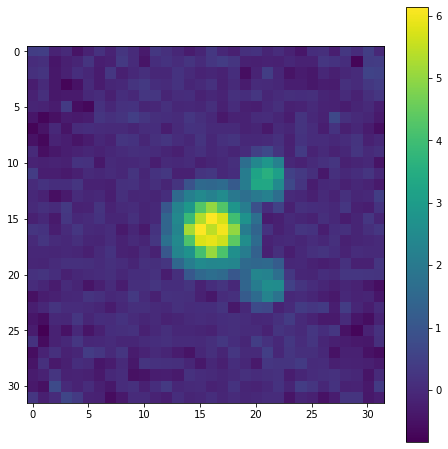

In [30]:
#mip_y(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1[:,:,0]))))
plt.colorbar()
#plt.title('Reconstruction slice')

Text(0.5, 1.0, 'Reconstruction MIP')

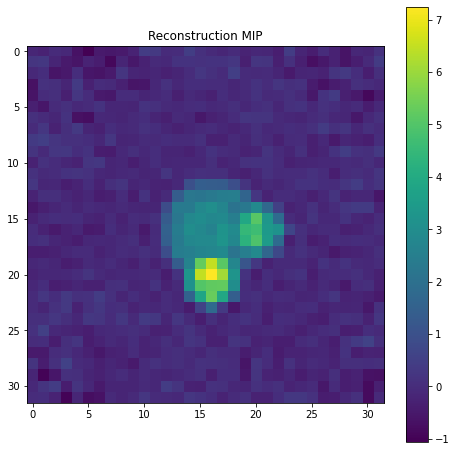

In [31]:
#mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2))))
plt.imshow(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg2[0,:,:]))))
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction relative error (Fourier)')

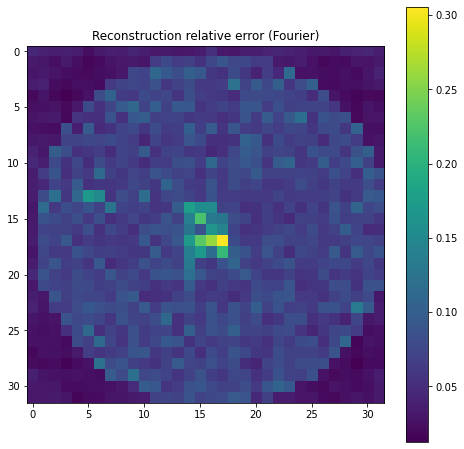

In [32]:
mip_z(jnp.abs(jnp.fft.fftshift((vcg1-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

Text(0.5, 1.0, 'Error in spatial domain with low freq vol - MIP')

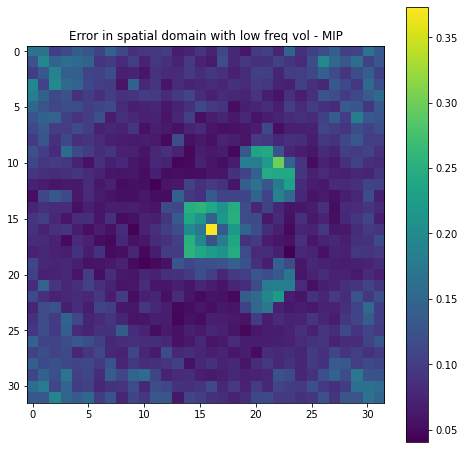

In [33]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier - vcg1)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

### FSC

In [34]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr = 0.05)

In [ ]:
points_v_tri = points_orientations_tri(angles_true[:int(N/2)], x_grid[1])
#points_v_nn = points_orientations_nn(angles_true, x_grid[1])

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow(jnp.fft.fftshift((points_v_tri[0,:,:]*mask[0,:,:]))); plt.colorbar()

In [ ]:
#res_spu, spu_nn = shell_points_used(points_v_nn, x_grid, dr = 0.05)
#plt.plot(res_spu, spu_nn)

### James

The mean is given by CG as applied above, in addition we need to calculate the variances.
The variances are given by the inverse of the gradient (AA) applied to diag(1), i.e. a volume with ones.

Looks good and agrees with counting the points above, but for whatever reason it's mirrored compared to above hmmm.

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

In [ ]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

In [ ]:
plt.title("Mean")
plt.imshow((jnp.abs(jnp.fft.fftshift(vcg1[:,:,0])))); plt.colorbar()

#### Train/test stuff - something's wrong here

In [ ]:
res

In [ ]:
loss = []
for radius in res[1:]:
    mask = create_3d_mask(x_grid, (0,0,0),radius)
    mask_imgs = mask[0,:,:].reshape(1,-1)
    ll = loss_func_sum(vcg1 * mask, angles_true[N2:], shifts_true[N2:], ctf_params[N2:], imgs[N2:]*mask_imgs)   
    loss.append(ll)
    
loss = jnp.array(loss)

#plt.imshow(jnp.fft.fftshift(mask[:,:,0]))

In [ ]:
plt.plot(res[1:], loss)

### SGD

In [ ]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
#v0 = vol_fourier + 0.1*v * mask
alpha = 10 # this alpha works well for full 128 x 128 x 128 volume with mask
batch_size = 2
N_iter = 1000  
#N_iter = 1000 

v = v0
for i in range(N_iter):
    
    idx = np.random.default_rng().choice(N, size=batch_size, replace = False)
    
    if jnp.mod(i,100) == 0:
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(v, angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx]))))

    v = v - alpha * jnp.conj(grad_loss_volume_batched(v, angles_true[idx], shifts_true[idx], ctf_params[idx], imgs[idx]))
    
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

In [ ]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(v, angles_true, shifts_true, ctf_params, imgs)))
print("Relative error = ", jnp.max(jnp.abs((v - vol_fourier)/jnp.max(vol_fourier))))

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift((v-vol_fourier)/jnp.max(vol_fourier))));plt.colorbar()

plt.title("Reconstruction relative error (Fourier)")

In [ ]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift((v)))) ; plt.colorbar()

In [ ]:
mip_z(jnp.abs(jnp.fft.fftshift(jnp.fft.ifftn((vol_fourier*mask - v*mask)))))
plt.colorbar()
plt.title('Error in spatial domain with low freq vol - MIP')

And the error with the high freq volume

In [ ]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - v)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')

In [ ]:
mip_z(jnp.abs(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vol_fourier - vol_fourier*mask)))))
plt.colorbar()
plt.title('Reconstruction error with high freq vol -  MIP')